In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

os.chdir('Downloads/parasitic-vs-uninfected')
if os.path.isdir('train/parasitic') is False:
    os.makedirs('train/parasitic')
    os.makedirs('train/uninfected')
    os.makedirs('valid/parasitic')
    os.makedirs('valid/uninfected')
    os.makedirs('test/parasitic')
    os.makedirs('test/uninfected')

    for i in random.sample(glob.glob('uninfected*'), 12000):
        shutil.move(i, 'train/uninfected')      
    for i in random.sample(glob.glob('parasitic*'), 12000):
        shutil.move(i, 'train/parasitic')
    for i in random.sample(glob.glob('uninfected*'), 1000):
        shutil.move(i, 'valid/uninfected')        
    for i in random.sample(glob.glob('parasitic*'), 1000):
        shutil.move(i, 'valid/parasitic')
    for i in random.sample(glob.glob('uninfected*'), 500):
        shutil.move(i, 'test/uninfected')      
    for i in random.sample(glob.glob('parasitic*'), 500):
        shutil.move(i, 'test/parasitic')

os.chdir('../../')

train_path = 'Downloads/parasitic-vs-uninfected/train'
valid_path = 'Downloads/parasitic-vs-uninfected/valid'
test_path = 'Downloads/parasitic-vs-uninfected/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(139,139), classes=['uninfected', 'parasitic'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(139,139), classes=['uninfected', 'parasitic'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(139,139), classes=['uninfected', 'parasitic'], batch_size=10, shuffle=False)

2023-01-06 11:02:26.293415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 24000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [2]:
print(test_batches)

In [3]:
img_dir = 'Downloads/parasitic-vs-uninfected/' # Directory of all images 
files = sorted([f for f in os.listdir(img_dir)])
# Read images (cv2.imread returns RGB numpy.ndarray)

final_files=[]

for file_name in files:
    if file_name[-3:]=="png":
        final_files.append(file_name)
#print(final_files)

imgs = [plt.imread(img_dir + file) for file in final_files]

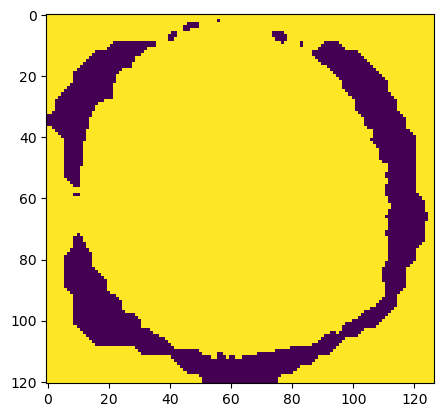

In [4]:
from skimage import filters
from skimage.color import rgb2gray
from PIL import Image

for img, filename in zip(imgs, final_files):
    
    img_gray = np.uint8(rgb2gray(img)*255) #convert to grayscale
    # threshold_img = cv2.fastNlMeansDenoising(img_gray, None, h=12)

    threshold_img = filters.gaussian(img_gray)
    threshold_img = filters.laplace(threshold_img)

    # threshold_img = np.uint8(normalize_intensity(threshold_img, 255, 0))
    # threshold_img = cv2.fastNlMeansDenoising(threshold_img, None, h=12)

    threshold_val = filters.threshold_yen(img_gray) #threashold image
    threshold_img = img_gray < threshold_val

    threshold_img = filters.median(threshold_img)
    
    threshold_img = np.array(threshold_img, dtype='float32')*255
    
    im = Image.fromarray(threshold_img)
    im = im.convert("L")
    im.save('Downloads/infected-vs-uninfected-transformed/'+ filename)
    
plt.imshow(threshold_img)

In [5]:
assert train_batches.n == 24000 
assert valid_batches.n == 2000 
assert test_batches.n == 1000 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

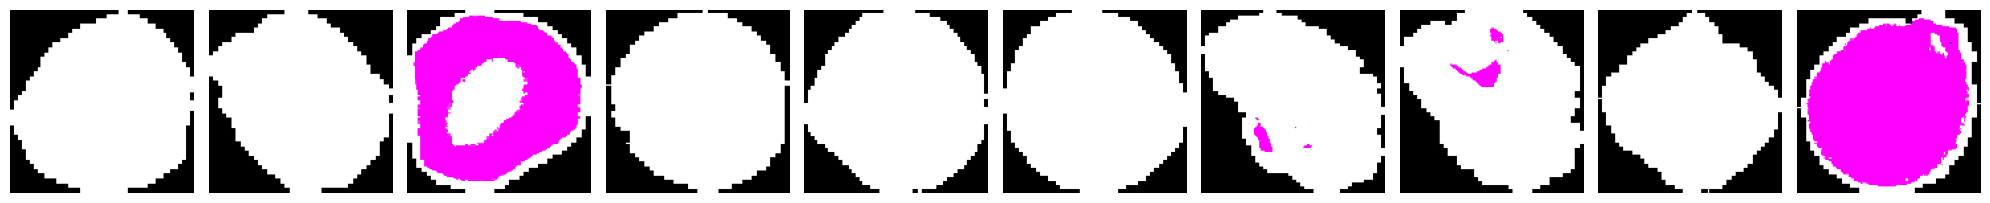

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(labels)

In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(139,139,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

2023-01-06 11:02:37.278939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 139, 139, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 69, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
2400/2400 - 269s - loss: 0.6930 - accuracy: 0.7908 - val_loss: 0.1901 - val_accuracy: 0.9430 - 269s/epoch - 112ms/step
Epoch 2/10
2400/2400 - 256s - loss: 0.1828 - accuracy: 0.9419 - val_loss: 0.1596 - val_accuracy: 0.9525 - 256s/epoch - 107ms/step
Epoch 3/10
2400/2400 - 252s - loss: 0.1541 - accuracy: 0.9491 - val_loss: 0.1463 - val_accuracy: 0.9510 - 252s/epoch - 105ms/step
Epoch 4/10
2400/2400 - 236s - loss: 0.1387 - accuracy: 0.9536 - val_loss: 0.1369 - val_accuracy: 0.9555 - 236s/epoch - 98ms/step
Epoch 5/10
2400/2400 - 236s - loss: 0.1253 - accuracy: 0.9578 - val_loss: 0.1730 - val_accuracy: 0.9560 - 236s/epoch - 98ms/step
Epoch 6/10
2400/2400 - 265s - loss: 0.1134 - accuracy: 0.9618 - val_loss: 0.1316 - val_accuracy: 0.9600 - 265s/epoch - 111ms/step
Epoch 7/10
2400/2400 - 279s - loss: 0.0975 - accuracy: 0.9673 - val_loss: 0.1646 - val_accuracy: 0.9490 - 279s/epoch - 116ms/step
Epoch 8/10
2400/2400 - 290s - loss: 0.0857 - accuracy: 0.9711 - val_loss: 0.1760 - val_accur

In [12]:
print(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

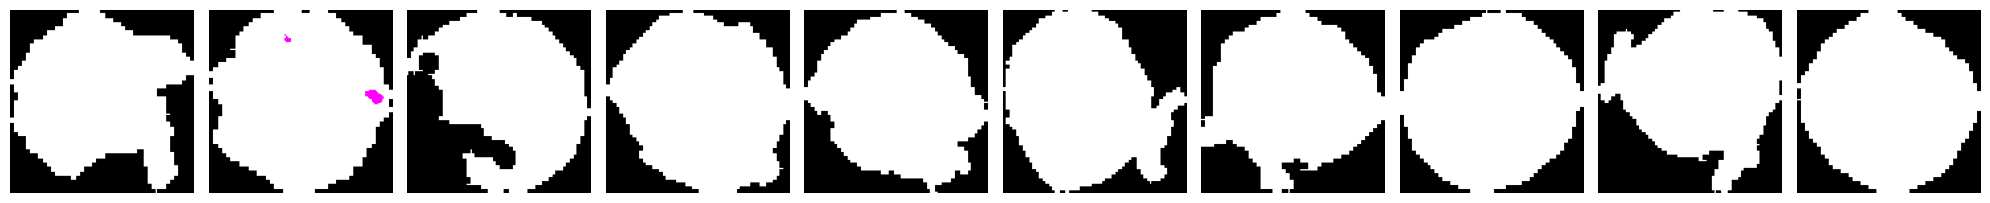

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [16]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'uninfected': 0, 'parasitic': 1}

Confusion matrix, without normalization
[[471  29]
 [ 28 472]]


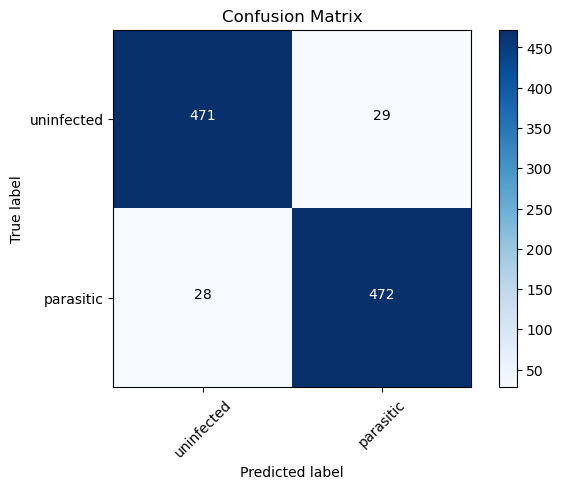

In [20]:
cm_plot_labels = ['uninfected','parasitic']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [21]:
test_accuracy = 100*(cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print("Test accuracy is: " + str(test_accuracy)+"%")

test_misclassification = 100*(cm[0][1] + cm[1][0])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print("Misclassification rate is: " + str(test_misclassification)+"%")

precision = 100*((cm[0][0])/(cm[0][0] + cm[0][1]))
print("Precision rate is: " + str(precision)+"%")

sensitivity = 100*((cm[0][0])/(cm[0][0] + cm[1][0]))
print("Sensitivity rate is: " + str(sensitivity)+"%")

specificity = 100*((cm[1][1])/(cm[1][1] + cm[0][1]))
print("Specificity rate is: " + str(specificity)+"%")

Test accuracy is: 94.3%
Misclassification rate is: 5.7%
Precision rate is: 94.19999999999999%
Sensitivity rate is: 94.38877755511022%
Specificity rate is: 94.2115768463074%


In [22]:
X = []
y = []
i = 0
for test_imgs, test_labels in test_batches:
    for img, label in zip(test_imgs, test_labels):
        X.append(img)
        y.append(label)
    i += 1
    if i == 50:
        break
        
X = np.array(X)

In [23]:
print(len(X))

500


In [24]:
X = np.array(X)

In [25]:
y_final = np.array([y_val[0] for y_val in y])

In [26]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X)
y_pred_final = np.array([round(y_val[0]) for y_val in y_pred_keras])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_final, y_pred_final)

16/16 [==============================] - 1s 83ms/step


In [27]:
from sklearn.metrics import auc

auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.9714285714285714


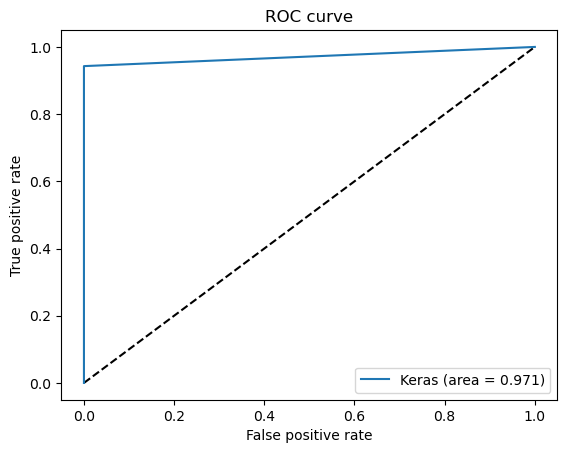

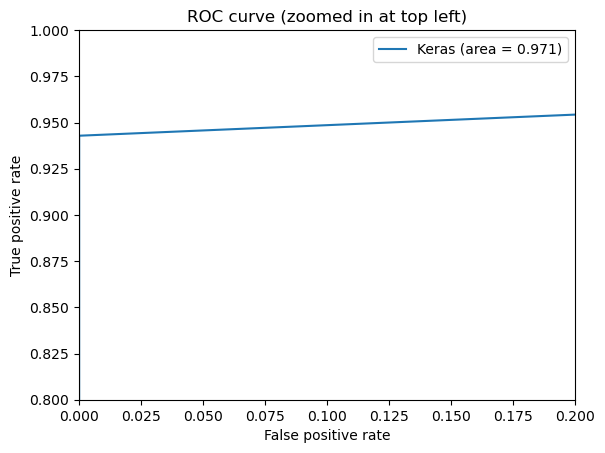

In [28]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [29]:
import pickle

In [30]:
model = pickle.load(open('Downloads.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'Downloads.pkl'